# Multi-Layered CNNs

In the previous unit we have learned about convolutional filters that can extract patterns from images. For our MNIST classifier we used 9 5x5 filters, resulting in 9x24x24 tensor.

We can use the same idea of convolution to extract higher-level patterns in the image. For example, rounded edges of digits such as 8 and 9 can be composed from a number of smaller strokes. To recognize those patterns, we can build another layer of convolution filters on top of the result of the first layer.

在上一单元中，我们学习了可以从图像中提取模式的卷积滤波器。 对于我们的 MNIST 分类器，我们使用了 9 个 5x5 过滤器，得到 9x24x24 张量。

我们可以使用相同的卷积思想来提取图像中的更高层次的模式。 例如，8 和 9 等数字的圆形边缘可以由许多较小的笔画组成。 为了识别这些模式，我们可以在第一层的结果之上构建另一层卷积过滤器。

In [2]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2023-02-09 12:46:19--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2023-02-09 12:46:19 (92.8 MB/s) - ‘pytorchcv.py’ saved [6540/6540]



In [3]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Pooling layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns, such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.

When doing so, we also need to apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within a sliding window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the **pooling layers**:

 * **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
 * **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

第一个卷积层寻找原始模式，例如水平或垂直线。 它们之上的下一层卷积层寻找更高层次的模式，例如原始形状。 更多的卷积层可以将这些形状组合成图片的某些部分，直到我们试图分类的最终对象。 这创建了提取模式的层次结构。

这样做时，我们还需要应用一个技巧：缩小图像的空间尺寸。 一旦我们检测到滑动窗口内有水平描边，它出现在哪个像素上就不再那么重要了。 因此我们可以`缩小`图像的大小，这是使用**池化层**之一完成的：

  * **平均池化**采用滑动窗口（例如，2x2 像素）并计算窗口内值的平均值
  * **Max Pooling** 用最大值替换窗口。 最大池背后的想法是检测滑动窗口中是否存在某种模式。

<img alt="Max Pooling" src="images/5-multilayer-convolutions-1.png" width="50%"/>

Thus, in a typical CNN there would be composed of several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

因此，在一个典型的 CNN 中，将由多个卷积层组成，在它们之间有池化层以减少图像的维度。 我们还会增加过滤器的数量，因为随着模式变得更高级 - 我们需要寻找更多可能的有趣组合。

![An image showing several convolutional layers with pooling layers.](images/5-multilayer-convolutions-2.png)

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called **pyramid architecture**. 

In the next example, we will use two-layered CNN:

由于减少空间维度和增加特征/过滤器维度，这种架构也被称为**金字塔架构**。

在下一个示例中，我们将使用双层 CNN：

In [4]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

Note a few things about the definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function, which is similar to `reshape` function in numpy. Since flattening layer does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from `torch.nn.functional` namespace.
* We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and thus one instance can be effectively reused.
* The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

注意关于定义的一些事情：
* 我们没有使用 `Flatten` 层，而是使用 `view` 函数将 `forward` 函数中的张量展平，这类似于 numpy 中的 `reshape` 函数。 由于展平层没有可训练的权重，因此我们不需要在我们的类中创建一个单独的层实例——我们可以只使用来自`torch.nn.functional`命名空间的函数。
* 我们在模型中只使用了一个池化层实例，也是因为它不包含任何可训练的参数，因此可以有效地重用一个实例。
* 可训练参数的数量 (~8.5K) 比以前的情况要少得多（感知器中为 80K，单层 CNN 中为 50K）。 发生这种情况是因为卷积层通常参数很少，与输入图像大小无关。 此外，由于池化，在应用最终致密层之前图像的维数显着降低。 少量参数对我们的模型有积极影响，因为即使在较小的数据集大小上，它也有助于防止过度拟合。

In [5]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.950, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.982, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.985, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.987, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.987, Val acc=0.984, Train loss=0.000, Val loss=0.000


What you should probably observe is that we are able to achieve higher accuracy, and much faster - just with 1 or 2 epochs. It means that sophisticated network architecture needs much fewer data to figure out what is going on, and to extract generic patterns from our images.

您可能应该观察到的是，我们能够以更快的速度实现更高的准确性——仅需 1 或 2 个 epoch。 这意味着复杂的网络架构需要更少的数据来弄清楚正在发生的事情，并从我们的图像中提取通用模式。

## Playing with real images from the CIFAR-10 dataset

While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore more advanced dataset of pictures of different objects, called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). It contains 60k 32x32 color images, divided into 10 classes. 


虽然我们的手写数字识别问题看起来像是一个玩具问题，但我们现在准备做一些更严肃的事情。 让我们探索更高级的不同对象图片数据集，称为 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)。 它包含 60k 32x32 彩色图像，分为 10 个类别。

In [6]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


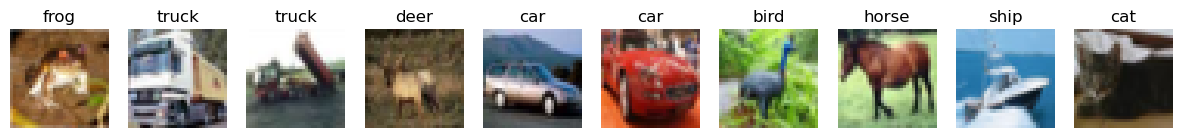

In [7]:
display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is $3\times32\times32$, and the $5\times5$ convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is $3\times5\times5$. 

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss function to optimize the model.


CIFAR-10 的一个著名架构称为 [LeNet](https://en.wikipedia.org/wiki/LeNet)，由 *Yann LeCun* 提出。 它遵循我们上面概述的相同原则。 然而，由于所有图像都是彩色的，输入张量大小为 $3\times32\times32$，$5\times5$ 卷积滤波器也应用于颜色维度 - 这意味着卷积核矩阵的大小为 $3\times5\times5$ .

我们还对该模型做了进一步的简化——我们不使用 `log_softmax` 作为输出激活函数，只返回最后一个全连接层的输出。 在这种情况下，我们可以只使用 `CrossEntropyLoss` 损失函数来优化模型。

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.

> In order to achieve better training results, we may need to experiment with some training parameters, such as learning rate. Thus, we explicitly define a *stochastic gradient descent* (SGD) optimizer here, and pass training parameters. You can adjust those parameters and observe how they affect training.

正确训练该网络将花费大量时间，最好在支持 GPU 的计算上完成。

> 为了达到更好的训练效果，我们可能需要对一些训练参数进行实验，比如学习率。 因此，我们在这里明确定义了一个*随机梯度下降*（SGD）优化器，并传递训练参数。 您可以调整这些参数并观察它们如何影响训练。

In [9]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.201, Val acc=0.331, Train loss=0.152, Val loss=0.129
Epoch  1, Train acc=0.400, Val acc=0.444, Train loss=0.117, Val loss=0.107
Epoch  2, Train acc=0.492, Val acc=0.508, Train loss=0.101, Val loss=0.098


The accuracy that we have been able to achieve with 3 epochs of training does not seem great. However, remember that blind guessing would only give us 10% accuracy, and that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy in such a short training time seems like a good accomplishment.

我们通过 3 个 epoch 的训练能够达到的准确度似乎并不高。 然而，请记住，盲目猜测只会给我们 10% 的准确率，而且我们的问题实际上比 MNIST 数字分类要困难得多。 在如此短的训练时间内获得 50% 以上的准确率似乎是一个很好的成就。

## Takeaways

In this unit, we have learned the main concept behind computer vision neural networks - convolutional networks. Real-life architectures that power image classification, object detection, and even image generation networks are all based on CNNs, just with more layers and some additional training tricks.

在本单元中，我们学习了计算机视觉神经网络背后的主要概念——卷积网络。 支持图像分类、目标检测甚至图像生成网络的现实架构都是基于 CNN，只是具有更多层和一些额外的训练技巧。